# __Project 1 - Exercise 2__

In [1]:
using LinearAlgebra, Plots, Statistics, VMLS, DataFrames

In [2]:
using MAT

vars = matread("FTIR_AMW_MLA310.mat");
X = vars["X"]; y = vars["y"];
CL1 = vars["CL1"]; CL2 = vars["CL2"]; 
Names1 = vars["Names1"]; Names2 = vars["Names2"];

In [3]:
vars

Dict{String, Any} with 8 entries:
  "X"          => [2.07795e-5 3.0227e-6 … -0.000481326 -0.00040964; 1.18043e-5 …
  "replicates" => [37.0; 38.0; … ; 191.0; 192.0;;]
  "Names1"     => ["Chicken", "Chicken", "Chicken", "Chicken", "Chicken", "Chic…
  "abcissas"   => [1799.43; 1797.5; … ; 702.027; 700.098;;]
  "CL2"        => [1.0; 1.0; … ; 2.0; 2.0;;]
  "Names2"     => ["Bird", "Bird", "Bird", "Bird", "Bird", "Bird", "Bird", "Bir…
  "CL1"        => [1.0; 1.0; … ; 4.0; 4.0;;]
  "y"          => [3393.8; 3227.95; … ; 1232.0; 1085.0;;]

### __2.1)__

In [4]:
using LinearAlgebra
using Statistics
function my_PCA(X; mc = 2)
# T, σ2, x̄, V, σ, U = my_PCA(X)
# ------------------------------------------------------------------
# Principal Component Analysis of data-matrix X (the input argument)
# ------------------------------------------------------------------
# The function returns
# T  - matrix of PCA-scores
# σ2 - the PCA-variances
# sσ2 - the total variance     
# x̄ - row vector of the X-column mean values
# V  - the PCA-loadings
# U  - the normalized prinicpal components
m,n = size(X)
mc  = min(mc, min(n,m)-1)  # Assure that the number of extracted components is consistent with the size of the problem.
x̄  = mean(X, dims=1)
U, σ, V = svd(X.-x̄); 
σ2  = (σ.^2)./(m-1);  # the PCA-variances    
sσ2 = sum(σ2);        # the total variance     
σ2  = σ2[1:mc];
U   = U[:,1:mc]; σ = σ[1:mc]; V = V[:,1:mc]; # Restriction to the first mc components.
T   = U.*σ';          # the PCA-scores
return T, σ2, sσ2, x̄, V, σ, U;
end

my_PCA (generic function with 1 method)

In [5]:
T, σ2, sσ2, x̄, V, σ, U = my_PCA(X; mc = 4);

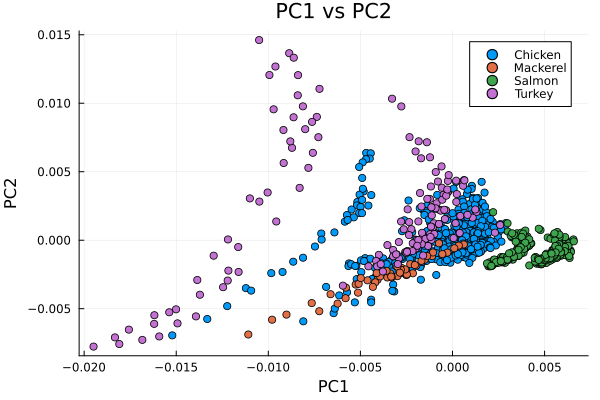

In [6]:
pc12 = scatter(T[:, 1], T[:, 2], xlabel = "PC1", ylabel = "PC2", title = "PC1 vs PC2", group=Names1)

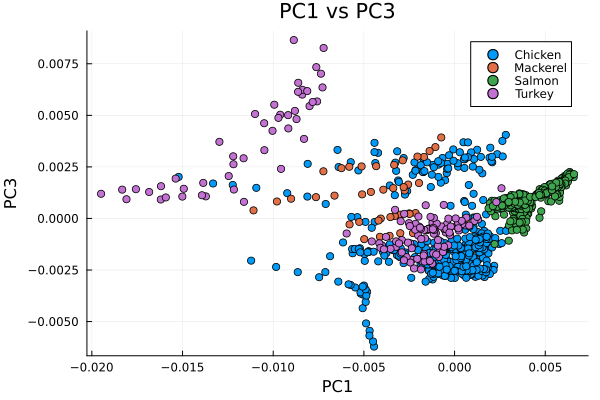

In [7]:
pc13 = scatter(T[:, 1], T[:, 3], xlabel = "PC1", ylabel = "PC3", title = "PC1 vs PC3", group=Names1)

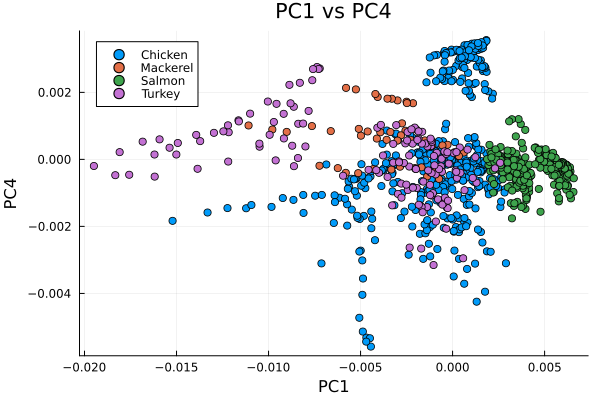

In [8]:
pc14 = scatter(T[:, 1], T[:, 4], xlabel = "PC1", ylabel = "PC4", title = "PC1 vs PC4", group=Names1)

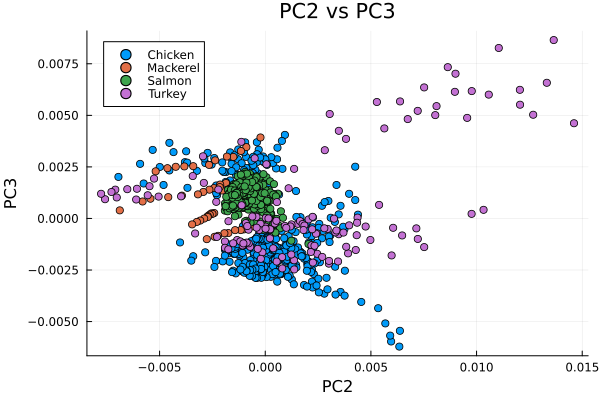

In [9]:
pc23 = scatter(T[:, 2], T[:, 3], xlabel = "PC2", ylabel = "PC3", title = "PC2 vs PC3", group=Names1)

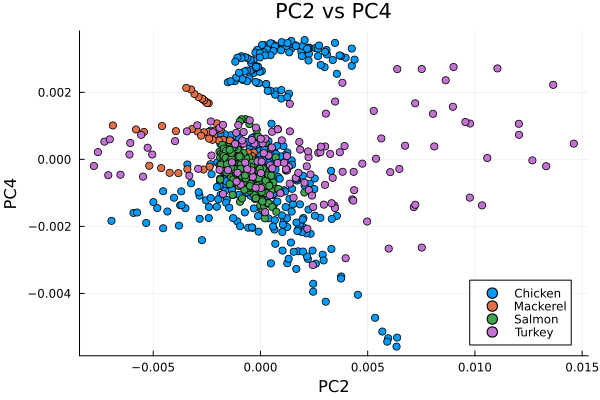

In [10]:
pc24 = scatter(T[:, 2], T[:, 4], xlabel = "PC2", ylabel = "PC4", title = "PC2 vs PC4", group=Names1)

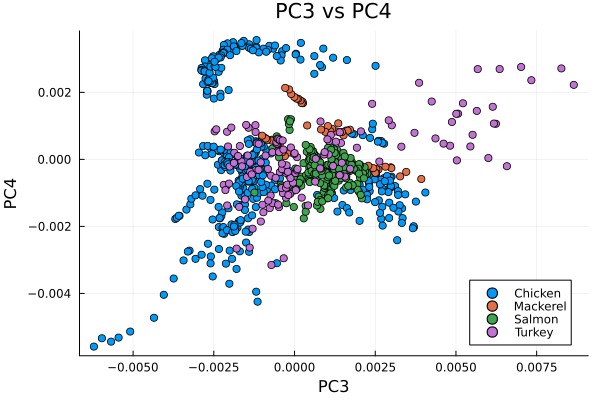

In [11]:
pc34 = scatter(T[:, 3], T[:, 4], xlabel = "PC3", ylabel = "PC4", title = "PC3 vs PC4", group=Names1)

Quick observations:
- The variance within class labels are consistent when plotting along the different principal components. I.e. salmon is quite compact across all the plots, meanwhile chicken and turkey are more spread out.

### __2.2)__

In [12]:
function plsHy(X, y; mc = 2)
    # ------------------- Initialize variables ----------------------
    m, n = size(X)
    mc = min(mc, min(n, m) - 1)
    T = zeros(m, mc);    W = zeros(n, mc);    Β = zeros(n, mc)
    P = zeros(n, mc);    q = zeros(1, mc);
    β₀ = zeros(mc);
    B = zeros(mc, 2); # B stored by diagonals (from paper)

    # ------------------- Mean center data ----------------------
    x̄   = mean(X, dims=1)     # - row vector of the X-column mean values.
    ȳ   = mean(y, dims=1)  # - the mean of the response values y.
    y   = y.- ȳ;              # - the centered response vector.
    X   = X.- x̄;              # - the centered X-data

    # ------------------- Calculate first component ----------------------
    w0 = X'y;    w = w0 / norm(w0);
    t = X * w;    ρ = norm(t);    t = t / ρ;    q[1] = (y't)[1]
    W[:, 1] = w;    T[:, 1] = t;    B[1, 1] = ρ;
    d = w / ρ;    Β[:, 1] = (t'y).*d;
    y = y - t * q[1]; # Deflate y
    P[:, 1] = X't;


    # ------------------- Calculate the rest of the components ----------------------
    for a = 2:mc
        w1 = X'y;   w = (w0 - w1)/q[a - 1] - ρ * w;   w0 = w1;
        w = w - W * (W'w);   θ = norm(w);   w = w / θ;
        t = X * w; t = t - T * (T't);
        ρ = norm(t);   t = t / ρ;   q[a] = (y't)[1];
        W[:, a] = w;   T[:, a]= t;
        B[a - 1, 2] = θ;   B[a, 1] = ρ;
        P[:, a] = X't;
    # ------------------- Update regression coefficients -------------------
        d = (w - θ * d) / ρ;
        Β[:, a] = Β[:, a - 1] + q[a].*d;
        y = y - t * q[a];
    end
    β₀ = ȳ .- x̄*Β;
    return β₀, Β, T, W, P, q;
end


plsHy (generic function with 1 method)

In [13]:
pc = 10;
m, ~ = size(X);
ŷ_globalPLS = zeros(m, pc);
samples = 1:m;
for i in samples
    β₀, β, ~, ~, ~, ~ = plsHy(X[samples .≠ i,:], y[samples .≠ i]; mc = pc)
    ŷ_globalPLS[i,:] = β₀ + X[i,:]'*β
end

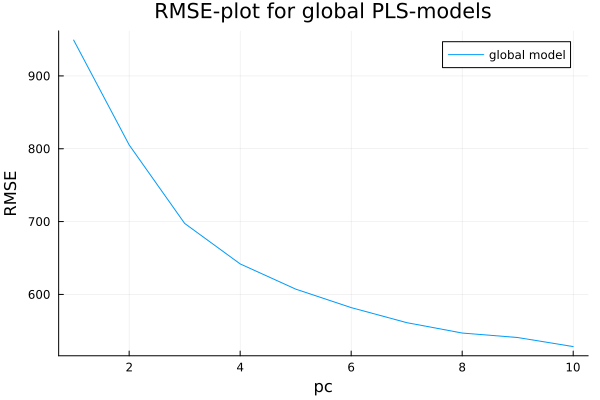

In [14]:
res_global = y.-ŷ_globalPLS;
RMSE_globalPLS = sqrt.(sum(res_global.^2, dims = 1)./m)'
RMSE_plot = plot((1:pc), RMSE_globalPLS, xlabel = "pc", ylabel = "RMSE", label = "global model", title = "RMSE-plot for global PLS-models")
display(RMSE_plot)

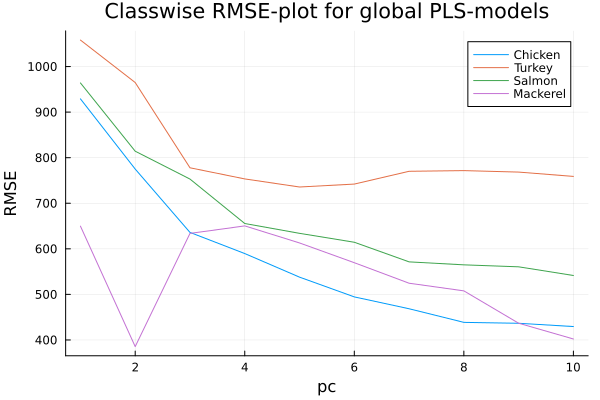

In [15]:
rmse_cl_plot = plot(xlabel="pc", ylabel="RMSE", title="Classwise RMSE-plot for global PLS-models")
for animal in unique(Names1)
    idx = findall(x -> x == animal, Names1)
    residuals = y[idx] .- ŷ_globalPLS[idx, :];
    rmse_cl = sqrt.(sum(residuals.^2, dims = 1)./length(idx))'
    plot!(rmse_cl_plot, rmse_cl, label=animal)
end
display(rmse_cl_plot)

### __2.3)__

In [16]:
function localPLS(X, y, animal; pc = 10)
    class_idx = findall(x -> x == animal, Names1)
    X_trunc = X[class_idx, :]; y_trunc = y[class_idx]
    m_trunc = size(X_trunc,1);
    ŷ = zeros(m_trunc, pc);
    samples = 1:m_trunc;
    for i in samples
        β₀, β, ~, ~, ~, ~ = plsHy(X_trunc[samples .≠ i,:], y_trunc[samples .≠ i]; mc = pc)
        ŷ[i, :] = β₀ + X_trunc[i, :]'*β
    end
    return ŷ, class_idx
end

localPLS (generic function with 1 method)

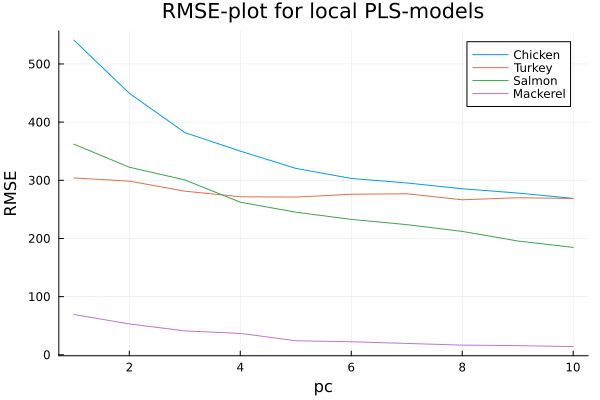

In [17]:
pc = 10;
m, ~ = size(X);
ŷ_localPLS = zeros(m, pc)
animals = unique(Names1)
local_plots = plot(xlabel="pc", ylabel="RMSE", title="RMSE-plot for local PLS-models")
for animal in animals
    ŷₓᵥ_animal, idx_animal = localPLS(X, y, animal, pc = pc)
    ŷ_localPLS[idx_animal, :] = ŷₓᵥ_animal
    res_animal = y[idx_animal] .- ŷₓᵥ_animal
    RMSE_animal = sqrt.(sum(res_animal.^2, dims = 1)./m)'
    # plot!(local_plots[i], RMSE_animal, label=animal, title=animal, legend=false)
    plot!(local_plots, RMSE_animal, label=animal)
end
display(local_plots)

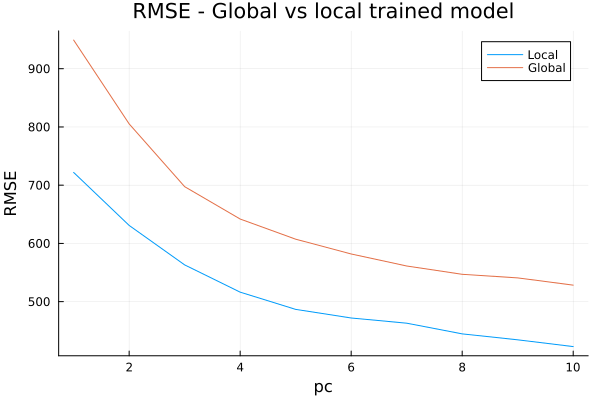

In [18]:
res_local = y.-ŷ_localPLS;
RMSE_localPLS = sqrt.(sum(res_local.^2, dims = 1)./m)'
plot((1:pc), RMSE_localPLS, xlabel = "pc", ylabel = "RMSE", label = "Local", title = "RMSE - Global vs local trained model")
plot!(RMSE_globalPLS, label = "Global")

### __2.4)__

In [19]:
"""
    RRLooCV_qr(X,y,λ; ρ = 1:length(y))

Ridge regression modelling alternative with faster LooCV-calculations

### Arguments
- `X` : data matrix of predictors.
- `y` : vector of responses.
- `λ` : the regularizarion parameter value.
- `q` : indices of the samples to be held out one-by-one in the Cross-validation

### Returns
- `β₀, β, resₓᵥ, ŷₓᵥ` : the constant term, the regression coeffs, the LooCV residuals and the LooCV predictions.

### Reference: 
.............

"""
function RRLooCV_qr(X,y,λ; ρ = 1:length(y))
# β0, β, yhat, res, yhatcv, rescv, Q, R, h = rrLooCV_QRfast(X,y,λ,ρ = cvrows);
# Inputs: data X, responses y, reg. param. λ and ρ = cvrows (specification of LooCV-samples).
# Outputs: β0, β, ŷₓᵥ
mρ  = length(ρ); m,n = size(X);
x̄   = mean(X, dims=1); ȳ = mean(y, dims=1); # - mean of data
y  = y.- ȳ ; X  = X.-x̄;              # - centering data.
Q,R = qr([X; sqrt(λ)*I]);  Q = Matrix(Q)[ρ,:];
β   = R\Q'y; β₀ = ȳ - x̄*β;           # The RR regression coeffs.  
res = y[ρ] - X[ρ,:]*β;               # Residuals for the samples specified by ρ.
h   = sum(Q[ρ,:].^2, dims=2) .+ 1/mρ; # The leverage values for the ρ-specified samples.
resₓᵥ= res./(1 .- h);                # LooCV-residuals for the specified samples.
ŷₓᵥ = (y.+ ȳ) - resₓᵥ;               # LooCV-predictions for the specified samples.
return β₀[1], β, resₓᵥ, ŷₓᵥ;
end

RRLooCV_qr

In [20]:
# λₛ = 10 .^(range(-5,stop=2,length=10))';
λₛ = 10 .^(range(-8,stop=2,length=10))';
nλ = length(λₛ);
ŷ_globalRR = zeros(m, nλ);
res_rr = zeros(m, nλ);

for i = 1:nλ
    β₀, β, res_rr[:, i], ŷ_globalRR[:, i] = RRLooCV_qr(X, y, λₛ[i]);
end

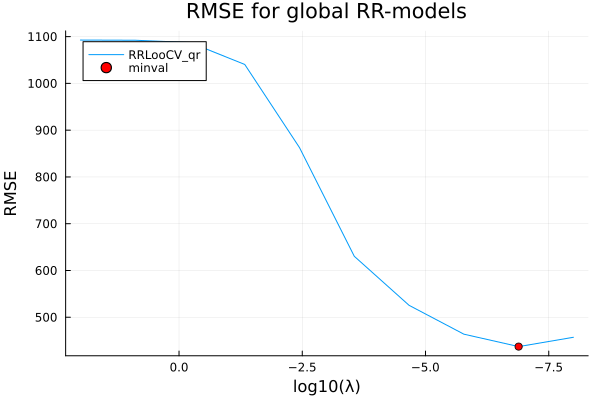

In [21]:
RMSE_globalRR = sqrt.(sum(res_rr.^2, dims = 1)./m)'
indmin = argmin(RMSE_globalRR)[1];
globalRR_plot = plot((log10.(λₛ')), RMSE_globalRR, xlabel = "log10(λ)", ylabel = "RMSE", label = "RRLooCV_qr", title = "RMSE for global RR-models", xflip=true)
scatter!(globalRR_plot, [log10(λₛ[indmin])], [RMSE_globalRR[indmin]], markershape = :circle, markercolor = :red, label = "minval")
display(globalRR_plot)

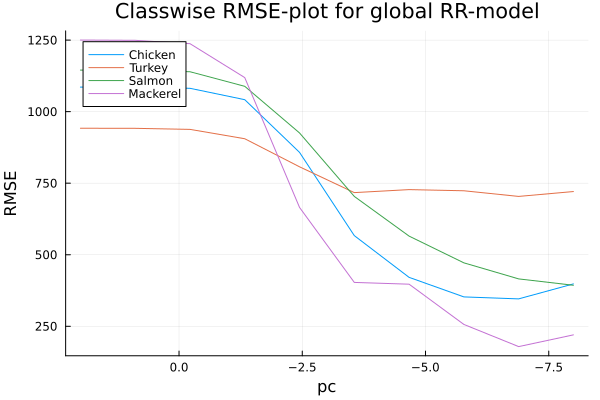

In [22]:
rmse_global_cl = plot(xlabel="pc", ylabel="RMSE", title="Classwise RMSE-plot for global RR-model", xflip=true)
for animal in unique(Names1)
    idx = findall(x -> x == animal, Names1)
    residuals = y[idx] .- ŷ_globalRR[idx, :];
    rmse_clRR = sqrt.(sum(residuals.^2, dims = 1)./length(idx))'
    plot!(rmse_global_cl, (log10.(λₛ')), rmse_clRR, label=animal)
end
display(rmse_global_cl)

In [23]:
function localRR(X, y, animal, λₛ)
    class_idx = findall(x -> x == animal, Names1)
    X_trunc = X[class_idx, :]; y_trunc = y[class_idx]
    nλ = length(λₛ);
    m_trunc = size(X_trunc, 1);
    ŷ = zeros(m_trunc, nλ);
    res_rr = zeros(m_trunc, nλ);

    for i = 1:nλ
        ~, ~, res_rr[:, i], ŷ[:, i] = RRLooCV_qr(X_trunc, y_trunc, λₛ[i]);
    end
    return ŷ, res_rr, class_idx
end

localRR (generic function with 1 method)

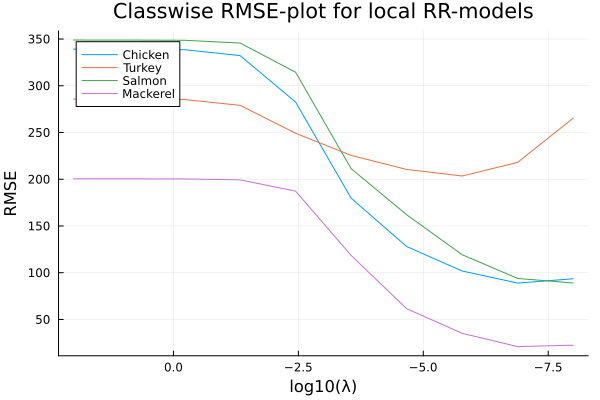

In [24]:
animals = unique(Names1)
# λₛ = 10 .^(range(-5,stop=2,length=10))';
λₛ = 10 .^(range(-8,stop=2,length=10))';
m, n = size(X)
ŷ_localRR = zeros(m, length(λₛ))
RMSE_animalRR = zeros(length(λₛ), length(animals))
localRR_plot = plot(xlabel="log10(λ)", ylabel="RMSE", title="Classwise RMSE-plot for local RR-models", xflip=true)
for (i, animal) in enumerate(animals)
    ŷₓᵥ_animal, res_animal, idx_animal = localRR(X, y, animal, λₛ)
    ŷ_localRR[idx_animal, :] = ŷₓᵥ_animal
    RMSE_animalRR[:, i] = sqrt.(sum(res_animal.^2, dims = 1)./length(ŷₓᵥ_animal))'
    plot!(localRR_plot, (log10.(λₛ')), RMSE_animalRR[:, i], label=animal)
end
display(localRR_plot)

In [25]:
λminRR = [λₛ[argmin(RMSE_animalRR[:, i], dims=1)[1]] for i in 1:length(animals)]
log10.(λminRR)

4-element Vector{Float64}:
 -6.888888888888889
 -5.777777777777778
 -8.0
 -6.888888888888889

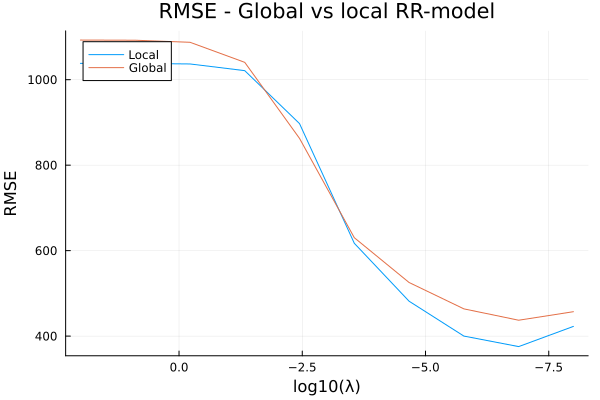

In [26]:
res_localRR = y.-ŷ_localRR;
RMSE_localRR = sqrt.(sum(res_localRR.^2, dims = 1)./m)'
rr_plot = plot(log10.(λₛ'), RMSE_localRR, label = "Local", xlabel = "log10(λ)", ylabel = "RMSE", title = "RMSE - Global vs local RR-model", xflip=true)
plot!(rr_plot, (log10.(λₛ')), RMSE_globalRR, label = "Global")

### __2.5)__

We define the main objective $k$ and consider the bi-objective as $k^c$ consisting of the remaining classes. We scale the bi-objectives for some value $\sqrt{w} << 1$, keeping the main objective unchanged, and use different regularization parameters $\lambda$ which best minimizes the error given our main objective.



$$
    \begin{bmatrix}
    X_k \\
    \sqrt{w} X_{k^c} \\
    \sqrt{\lambda} I
    \end{bmatrix}

    \beta = 

    \begin{bmatrix}
    y_k \\
    \sqrt{w} y_{k^c} \\
    \sqrt{\lambda} 0
    \end{bmatrix}
$$

<br>
Predictions are made by using the regression coefficients, gained by solving the MOLS problem, multiplied with the main objective. We then store them in a prediction matrix where each column represents the different w-values we have scaled the bi-objectives with. I.e. if "Chicken" is the main objective, we only store predictions where the samples' indicies are related to "Chicken". The RMSE is then calculated from this common prediciton matrix.

In [27]:
mols_solve_(As,bs,λs) = vcat(sqrt.(λs).*As ...)\vcat(sqrt.(λs).*bs ...);

In [28]:
m, n = size(X);
λₛ = 10 .^(range(-8,stop=2,length=30))';
animals = unique(Names1)

ŷ_mols = zeros(m, length(λₛ));
J = zeros(length(λₛ), 2, length(animals)) # 1st column main obj, 2nd column bi-obj

w = 10^-2 # weight of bi-objective
for (i, animal) in enumerate(animals) # For each animal/main objective
    main = findall(x -> x == animal, Names1) # main objective
    bi = findall(x -> x != animal, Names1) # bi-objective
    J1 = zeros(length(λₛ)); J2 = zeros(length(λₛ));
    J_i = zeros(length(λₛ), length(animals))
    
    for (j, λ) in enumerate(λₛ) # For each regularization parameter
        As = [X[main, :], X[bi, :], eye(n)]
        Y = [y[main], y[bi], zeros(n, 1)]
        c = [1, w, λ]
        β_λ = mols_solve_(As, Y, c)
        J[j, 1, i] = norm(As[1] * β_λ - Y[1])^2
        J[j, 2, i] = norm(As[2] * β_λ - Y[2])^2
        ŷ_mols[main, j] = As[1] * β_λ;
    end
end

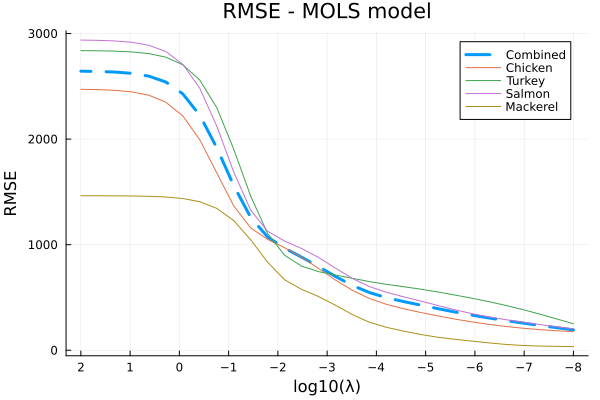

In [29]:
RMSE_MOLS = sqrt.(sum((y .- ŷ_mols).^2, dims=1)./m)'
MOLSw_plot = plot(xlabel = "log10(λ)", ylabel="RMSE", title="RMSE - MOLS model", xflip=true, xticks=-8:2, legend=:topright)
plot!(MOLSw_plot, log10.(λₛ'), RMSE_MOLS, xflip=true, linewidth=3, linestyle=:dash, label="Combined")
for animal in unique(Names1)
    idx = findall(x -> x == animal, Names1)
    residuals = y[idx] .- ŷ_mols[idx, :];
    rmse_clMOLS = sqrt.(sum(residuals.^2, dims = 1)./length(idx))'
    plot!(MOLSw_plot, log10.(λₛ'), rmse_clMOLS, label=animal)
end
display(MOLSw_plot)

In [30]:
# Get the λ-value that minimizes the RMSE for each animal
λ_minMOLS = zeros(length(animals))
for (i, animal) in enumerate(animals)
    idx = findall(x -> x == animal, Names1)
    λ_minMOLS[i] = λₛ[argmin(sqrt.(sum((ŷ_mols[idx, :] .- y[idx]).^2, dims=1)./length(idx)))[1]]
end

In [31]:
λ_df = DataFrame()
λ_df[!, :Species] = animals
λ_df[!, :RR] = log10.(λminRR)
λ_df[!, :MOLS] = log10.(λ_minMOLS)
λ_df

4×3 DataFrame
 Row │ Species   RR        MOLS    
     │ String    Float64   Float64 
─────┼─────────────────────────────
   1 │ Chicken   -6.88889     -8.0
   2 │ Turkey    -5.77778     -8.0
   3 │ Salmon    -8.0         -8.0
   4 │ Mackerel  -6.88889     -8.0

### __2.6)__

In [32]:
# Calculate classwise RMSEs for each model
RMSEs_model = zeros(length(animals), 5)
for (i, ŷ) in enumerate([ŷ_globalPLS, ŷ_localPLS, ŷ_globalRR, ŷ_localRR, ŷ_mols])
    for (j, animal) in enumerate(animals)
        idx = findall(x -> x == animal, Names1)
        res_model = y[idx] .- ŷ[idx, :]
        RMSE_local = sqrt.(sum(res_model.^2, dims = 1)./length(idx))'
        RMSEs_model[j, i] = minimum(RMSE_local, dims=1)[1]
    end
end

In [33]:
species = unique(Names1)
model_RMSEs = DataFrame()
model_RMSEs[!, :Species] = species

for (i, model) in enumerate(["globalPLS", "localPLS", "globalRR", "localRR", "MOLS"])
    model_RMSEs[!, Symbol(model)] = RMSEs_model[:, i]
end

model_RMSEs

4×6 DataFrame
 Row │ Species   globalPLS  localPLS  globalRR  localRR   MOLS     
     │ String    Float64    Float64   Float64   Float64   Float64  
─────┼─────────────────────────────────────────────────────────────
   1 │ Chicken     429.431  388.395    345.736  281.169   175.537
   2 │ Turkey      735.667  667.567    703.818  643.349   250.427
   3 │ Salmon      541.458  332.416    393.29   281.436   202.512
   4 │ Mackerel    385.449   60.9337   178.985   66.2462   34.5454